## the following part is for the noise generation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

def add_gaussian_noise(img, mean = 0, var = 0.01):
    # generate gaussian noise with mean and var.

    H,W,C= img.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(H,W,C))
    gauss = gauss.reshape(H,W,C)
    noisy = img + gauss
    
    return noisy

def add_uniform_noise(img, bound = 0.2):
    # generate uniform noise with interval [-bound, bound]
    H,W,C= img.shape
    uni = (np.random.rand(H,W,C)-0.5)/0.5*bound
    noisy = img + uni
    return noisy

def add_snp_noise(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i, int(num_salt))
          for i in image.shape]
    print(coords)
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    out = out*2-1
    return out

## Gaussian noise training set generation

In [21]:
img2 = np.zeros((64, 64))

for i in range(10000):
    var = 0.01
    random_noisy_image = (np.random.rand(64, 64)-0.5)/0.5*0.25
    
    np.save('1d_noise/uniform/{:05d}.npy'.format(i), random_noisy_image)
#     rimg = cv2.cvtColor((random_noisy_image * 255.).astype(np.uint8), cv2.COLOR_RGB2BGR)
#     cv2.imwrite('train_gaussian_noise/{:05d}.png'.format(i), rimg)
#     fig, ax = plt.subplots(1,2,figsize = (16, 8))
#     ax[0].imshow(random_noisy_image)
#     ax[1].hist(random_noisy_image.flatten(), bins = 20)
#     plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


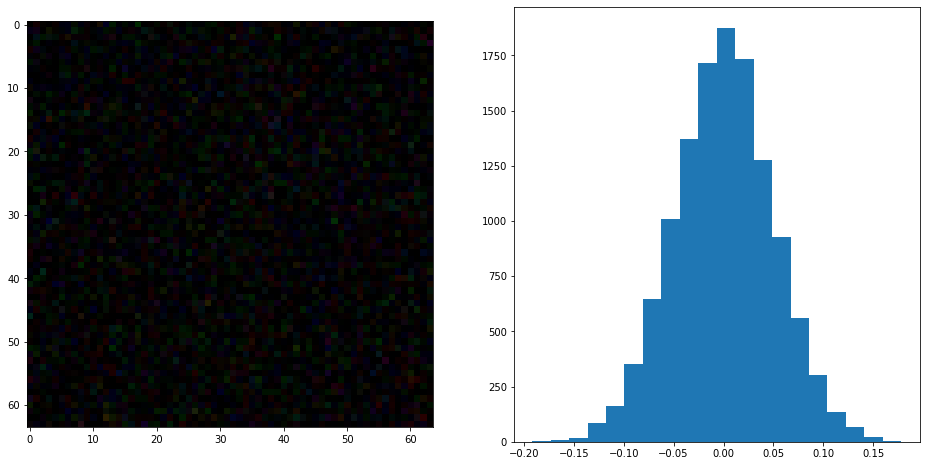

In [20]:
img2 = np.zeros((64, 64, 3))

for i in range(1):
    var = 0.0025
    random_noisy_image = add_gaussian_noise(img2, var = var)
    
    #np.save('train_mixed_gaussian/{:05d}.npy'.format(i), random_noisy_image)
#     rimg = cv2.cvtColor((random_noisy_image * 255.).astype(np.uint8), cv2.COLOR_RGB2BGR)
#     cv2.imwrite('train_gaussian_noise/{:05d}.png'.format(i), rimg)
    fig, ax = plt.subplots(1,2,figsize = (16, 8))
    ax[0].imshow(random_noisy_image)
    ax[1].hist(random_noisy_image.flatten(), bins = 20)
    plt.show()

(array([121., 421., 252., 122.,  42.,  25.,  12.,   4.,   0.,   1.]),
 array([0.00102422, 0.0055931 , 0.01016197, 0.01473084, 0.01929972,
        0.02386859, 0.02843746, 0.03300633, 0.03757521, 0.04214408,
        0.04671295]),
 <a list of 10 Patch objects>)

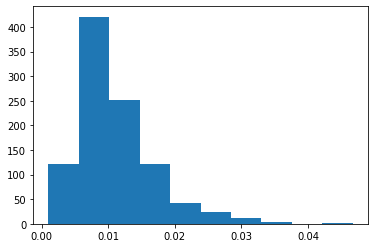

In [15]:
var = np.random.lognormal(mean = np.log(0.01), sigma = 0.5, size = 1000)
plt.hist(var)

In [15]:
img2 = np.zeros((64, 64))

for i in range(10000):
    var = np.random.lognormal(mean = np.log(0.01), sigma = 0.5)
    sigma = var**0.5
    random_noisy_image = np.random.normal(0,sigma,(64, 64))#add_gaussian_noise(img2, var = var)
    
    np.save('1d_noise/mixed_gauss/{:05d}.npy'.format(i), random_noisy_image)
#     rimg = cv2.cvtColor((random_noisy_image * 255.).astype(np.uint8), cv2.COLOR_RGB2BGR)
#     cv2.imwrite('train_gaussian_noise/{:05d}.png'.format(i), rimg)
#     fig, ax = plt.subplots(1,2,figsize = (16, 8))
#     ax[0].imshow(random_noisy_image)
#     ax[1].hist(random_noisy_image.flatten(), bins = 20)
#     plt.show()

## the following part is for noise patches extraction.

In [ ]:
import h5py
## 0001.mat is from database DND https://noise.visinf.tu-darmstadt.de
with h5py.File('0001.mat', 'r') as f:
    img = np.stack(list(f['InoisySRGB']), axis = 2)

plt.imshow(img)
plt.show()

In [ ]:
### The principles of extracting patches are based on Image Blind Denoising paper by Chen.
def slice_(img, size, stride):
    # slice the image into patches with given size and iterate with given stride
    H, W, C = img.shape
    slides = []
    
    for i in range(0, H-size, stride):
        for j in range(0, W-size, stride):
            slides.append(img[i:i+size, j:j+size])
    
    return slides

def is_smooth(patch, mu = 0.1, gamma = 0.25):
    # decide whether the global patch is smooth by comparing its mean/variance with every local patch
    mu_patch = np.mean(patch)
    var_patch = np.var(patch)
    for qij in slice_(patch, 16, 16):
        if np.abs(np.mean(qij) - mu_patch) > mu * mu_patch:
            return False
        if np.abs(np.var(qij) - var_patch) > gamma * var_patch:
            return False
        
    return True

def noise_patch(img):
    # patch size: 64 x 64; iterate patch with stride : (32, 32)
    V = []
    for pi in slice_(img, 64, 32):
        if is_smooth(pi):
            V.append(pi - np.mean(pi))
    V = np.stack(V)
    return V

In [ ]:
V = noise_patch(img)
print(V.shape)
print("sanity check - max/min of V[0]: {} {}".format(np.max(V[0]), np.min(V[0])))